In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
#from os import walk
#import re

import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [39]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return od(reversed(list(S.items())))

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [40]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    return {"S": result, "L": heat["L"], "D": heat["D"], "R": heat["R"]}

def calc_hc(st, T):

    fe = mp.mpf(1.0) * np.array([e for e, S in st['S'].items()])
    fS = mp.mpf(1.0) * np.array([S for e, S in st['S'].items()])

    exp = np.frompyfunc(mp.exp, 1, 1)
    w = exp(fS - fe / T)

    Z = w.sum()
    E = (w * fe).sum()
    E_sq = (w * fe * fe).sum()
    E_qr = (w * fe * fe * fe * fe).sum()
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))


In [41]:
T_crit = {}

In [141]:
T_crit = {}
D = 1.967
L = [96]#[8, 12, 16, 20, 24, 32, 48, 64, 80, 96]

R = [32768, 131072]

cool, heat = [{
    "q": 3,
    "D": D,
    "L": l,
    #"R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
} for l in L], [{
    "q": 3,
    "D": D,
    "L": l,
    #"R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
} for l in L]
print('D={}'.format(D))

parameters = []
for c, h in zip(tqdm(cool), heat):
    try:
        c['R'] = R[1]
        h['R'] = R[1]
        parameters.append(read_tuple_files((c, h)))
    except:
        try:
            c['R'] = R[0]
            h['R'] = R[0]
            parameters.append(read_tuple_files((c, h)))
        except:
            pass
        
for i, x in enumerate(parameters):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))


D=1.967


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """



L in 


In [140]:
for p in parameters:
    cool, heat, st = p['cool'], p['heat'], p['stitched']

    plt.figure(figsize=(16, 9))

    plt.plot([x for x in cool['culling_factor']], [y for x, y in cool['culling_factor'].items()], 'o')
    plt.plot([x for x in heat['culling_factor']], [y for x, y in heat['culling_factor'].items()], 'o')
    plt.grid()

    plt.title("$D={}; L={}; R={}$".format(st["D"], st["L"], st["R"]), fontsize=16)
    plt.ylabel('$culling\_factor(E)$', fontsize=16)
    plt.xlabel('$E$', fontsize=16)
    plt.show()
    #plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


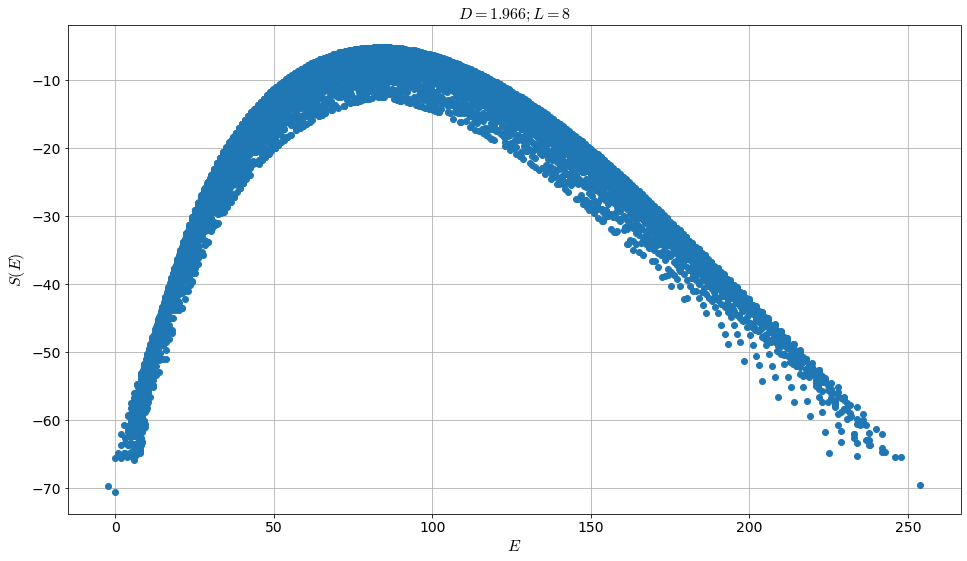

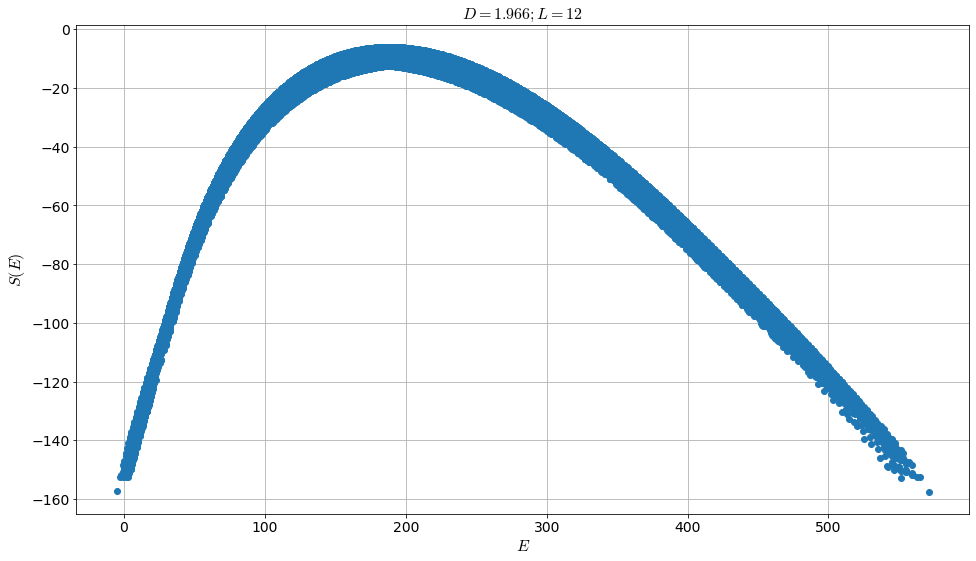

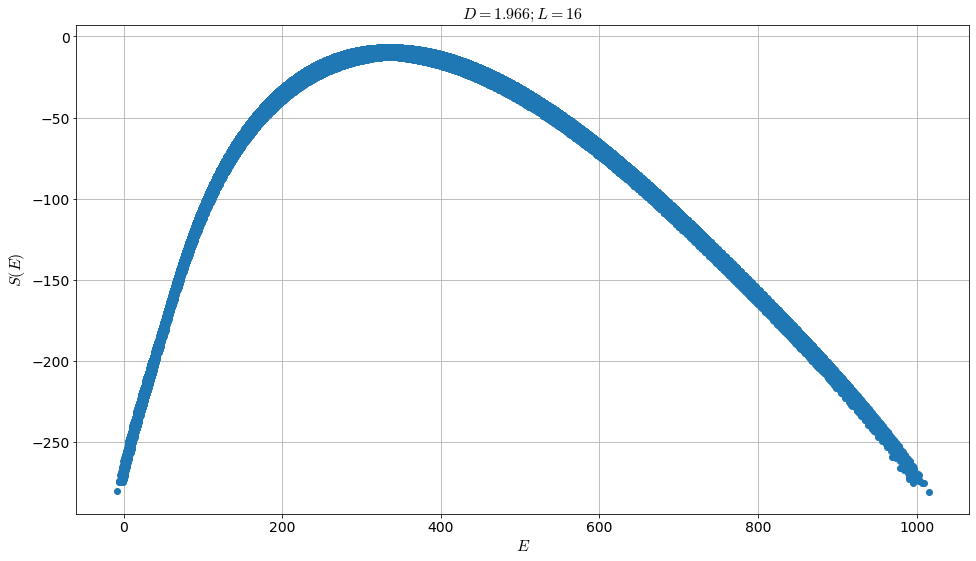

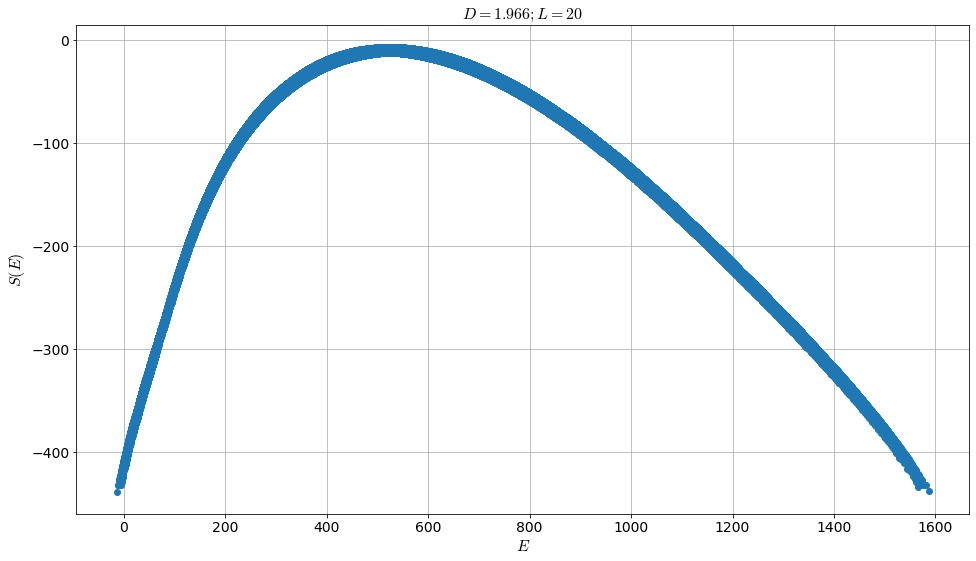

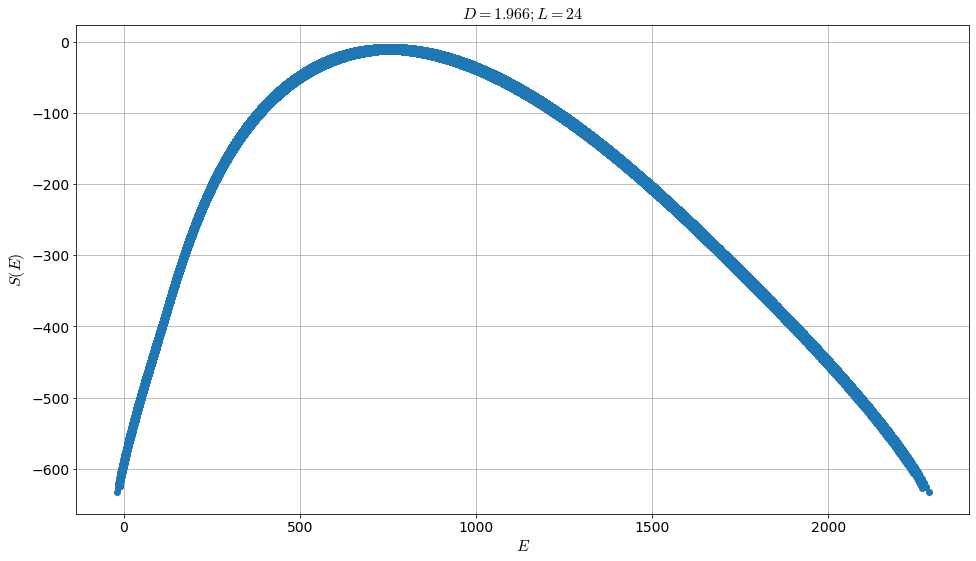

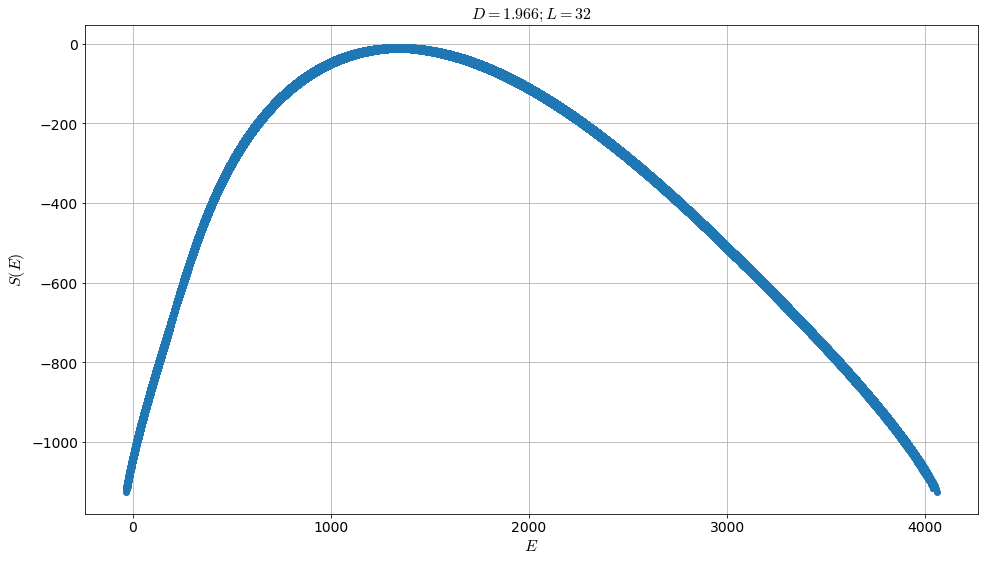

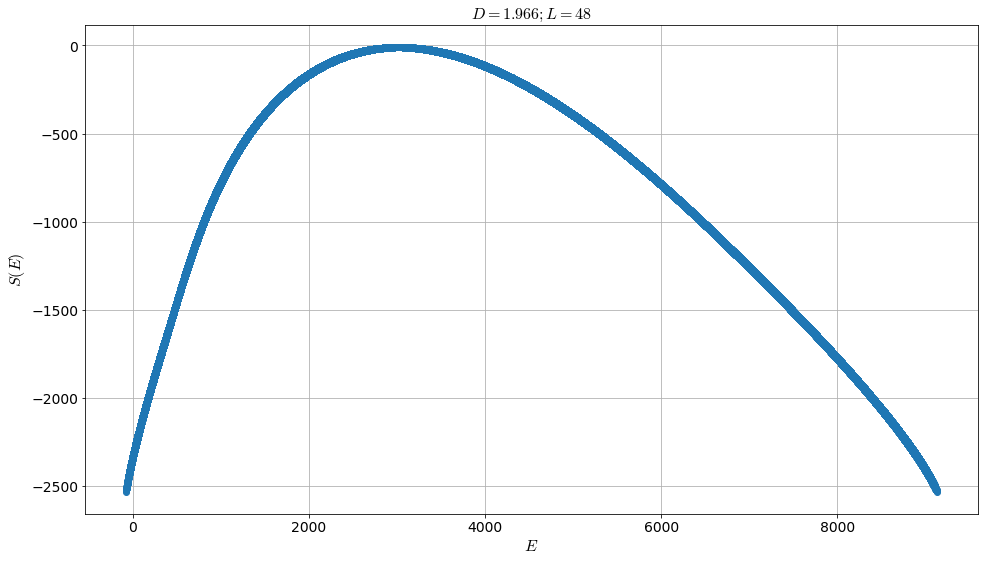

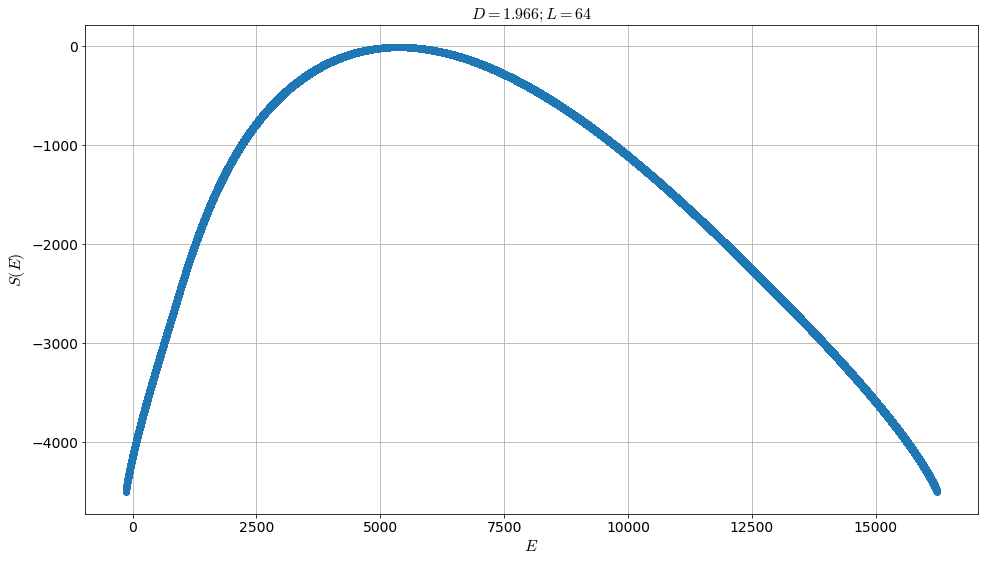

In [109]:
for p in parameters:

    plt.figure(figsize=(16, 9))

    cool, heat, st = p['cool'], p['heat'], p['stitched']

    plt.plot([x for x in st['S']], [y for x, y in st['S'].items()], 'o')
    plt.grid()
    plt.title("$D={}; L={}$".format(st["D"], st["L"], st["R"]), fontsize=16)
    plt.ylabel('$S(E)$', fontsize=16)
    plt.xlabel('$E$', fontsize=16)
    #savefig("./images/S(E)_D{}_L{}.png".format(st["D"], st["L"]))
    plt.show()

In [116]:
len(parameters[-1]['stitched']['S'])

2454198

In [83]:
D

1.966

In [46]:


a = 0.3
b = 1.8

for x in tqdm(parameters):
    st = x["stitched"]
    L = st["L"]
    t, c, _, _ = fminbound(lambda T: -calc_hc(st, T)[1], a, b, maxfun=500, full_output=1, disp=False)
    T_crit[L] = {
        "T_crit": float(t),
        "C_crit": float(-c / (L * L))
    }

print(T_crit)




{8: {'T_crit': 0.5655598545704739, 'C_crit': 1.3117213817192757}}


In [20]:
with open('./tmp/T_crit_D{}.txt'.format(D), 'w') as f:
    json.dump(T_crit, f)

In [18]:
print('L & ' + ' & '.join([str(L) for L in T_crit]) + ' \\\\')
print('$T_{crit}$ & ' + ' & '.join([str(T_crit[L]['T_crit'])[:6] for L in T_crit]) + ' \\\\')
print('$C_{crit}$ & ' + ' & '.join([str(T_crit[L]['C_crit'])[:6] for L in T_crit]) + ' \\\\')

L & 8 & 12 & 16 & 20 & 24 & 32 & 48 & 64 & 96 \\
$T_{crit}$ & 0.5655 & 0.5295 & 0.5028 & 0.4969 & 0.5613 & 0.5525 & 0.5546 & 0.5695 & 0.5644 \\
$C_{crit}$ & 1.3117 & 1.4595 & 1.6375 & 2.0554 & 1.1073 & 1.1126 & 1.1010 & 1.1005 & 1.1198 \\


In [29]:
for D in [0.0, 0.5, 1.0, 1.5, 1.6, 1.7, 1.75, 1.87, 1.9, 1.92, 1.94, 1.95, 1.96, 1.962, 1.964, 1.965, 1.965, 1.966, 1.967, 1.97, 1.98, 1.99]:
    with open('./tmp/T_crit_D{}.txt'.format(D), 'r') as f:
        T_crit = json.load(f)

    with open('./tmp/T_crit_D{}.tsv'.format(D), 'w') as f:
        f.write('L\tT_crit\tC_crit\n');
        for L in T_crit:
            f.write('\t'.join([L, str(T_crit[L]['T_crit']), str(T_crit[L]['C_crit'])]) + '\n')


In [154]:
with open('./tmp/T_crit_D{}.txt'.format(D), 'r') as f:
    T_crit = json.load(f)

In [23]:
T_crit

{'8': {'T_crit': 1.1347768808167538, 'C_crit': 1.3747331326566898},
 '12': {'T_crit': 1.1519879172997154, 'C_crit': 1.5982693945940192},
 '16': {'T_crit': 1.158340522180259, 'C_crit': 1.7617762462175466},
 '20': {'T_crit': 1.1565634357713444, 'C_crit': 1.895148128059344},
 '24': {'T_crit': 1.1592087091603878, 'C_crit': 1.988597364227788},
 '32': {'T_crit': 1.1548429319612816, 'C_crit': 2.152657950209968},
 '48': {'T_crit': 1.156772446301583, 'C_crit': 2.396480466685775},
 '64': {'T_crit': 1.1545972539491516, 'C_crit': 2.555612989531898},
 '80': {'T_crit': 1.155636262756524, 'C_crit': 2.771162015021736},
 '96': {'T_crit': 1.151710698119789, 'C_crit': 2.806470144606915}}

D=1.5; L=96


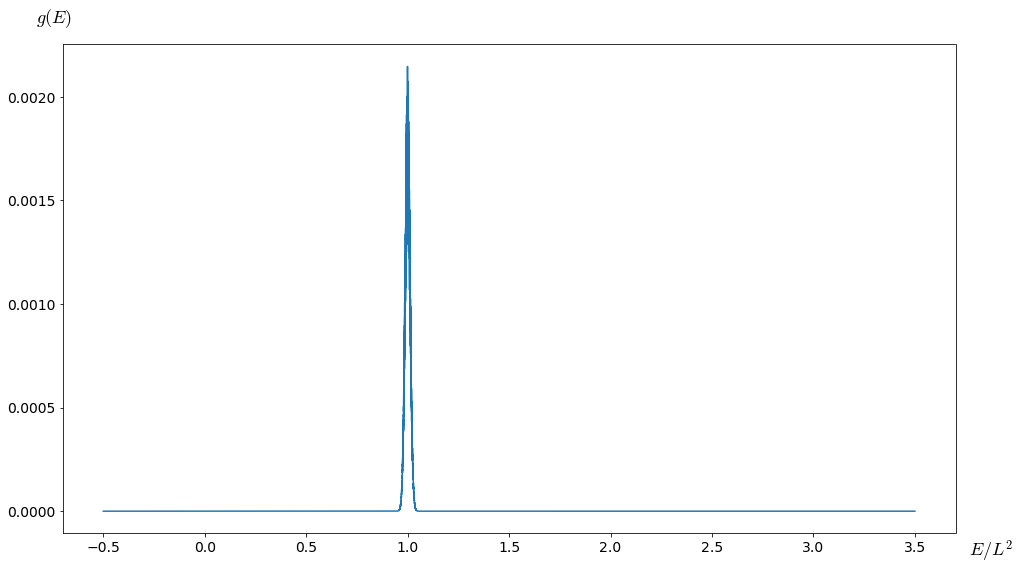

In [100]:
p = parameters[-1]

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

#ax.set_xlim([0.05, 0.43])
ax.set_ylabel("$g(E)$", rotation=0, fontsize=18)
#ax.set_ylabel("$\ln g(E)$", rotation=0, fontsize=18)
#ax.set_ylabel("$S(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

#plt.figure(figsize=(16, 9))

cool, heat, st = p['cool'], p['heat'], p['stitched']
L = st["L"]

plt.plot([x / (L*L) for x in st['S']], np.exp([y for x, y in st['S'].items()]) , '-')
print("D={}; L={}".format(st["D"], st["L"], st["R"]))
#plt.title("$D={}; L={}$".format(st["D"], st["L"], st["R"]), fontsize=16)
#plt.yscale('log')
#plt.ylabel('$S(E)$', fontsize=16)
#plt.xlabel('$E$', fontsize=16)
#plt.grid()
plt.savefig("./images/S(E)_D{}_L{}_pretty_g.png".format(st["D"], st["L"]))
#plt.show()

D=1.5; L=96


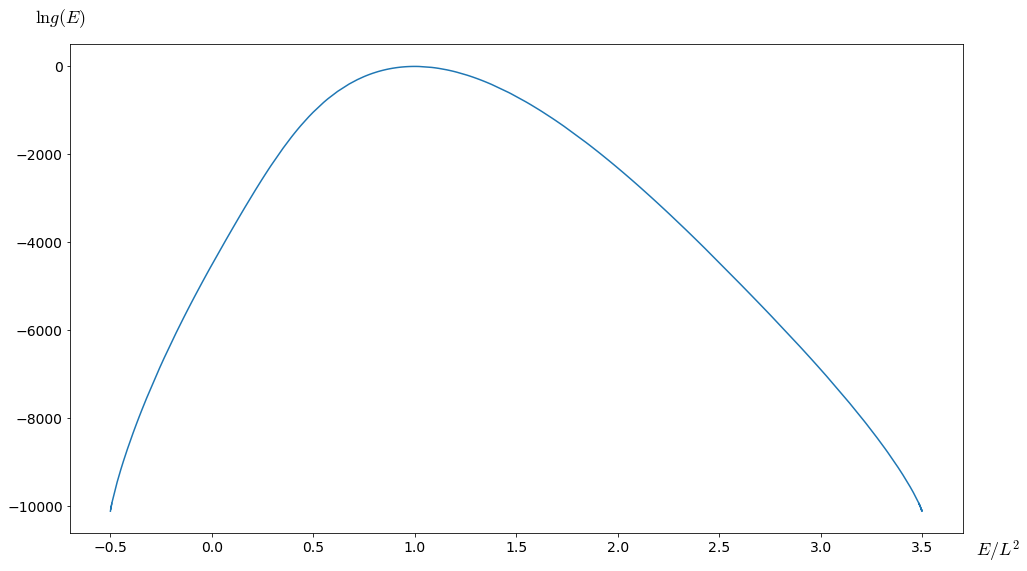

In [101]:
p = parameters[-1]

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

#ax.set_xlim([0.05, 0.43])
#ax.set_ylabel("$g(E)$", rotation=0, fontsize=18)
ax.set_ylabel("$\ln g(E)$", rotation=0, fontsize=18)
#ax.set_ylabel("$S(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

#plt.figure(figsize=(16, 9))

cool, heat, st = p['cool'], p['heat'], p['stitched']
L = st["L"]

plt.plot([x / (L*L) for x in st['S']], ([y for x, y in st['S'].items()]) , '-')
print("D={}; L={}".format(st["D"], st["L"], st["R"]))
#plt.title("$D={}; L={}$".format(st["D"], st["L"], st["R"]), fontsize=16)
#plt.yscale('log')
#plt.ylabel('$S(E)$', fontsize=16)
#plt.xlabel('$E$', fontsize=16)
#plt.grid()
plt.savefig("./images/S(E)_D{}_L{}_pretty_lng.png".format(st["D"], st["L"]))
#plt.show()

D=1.5; L=96


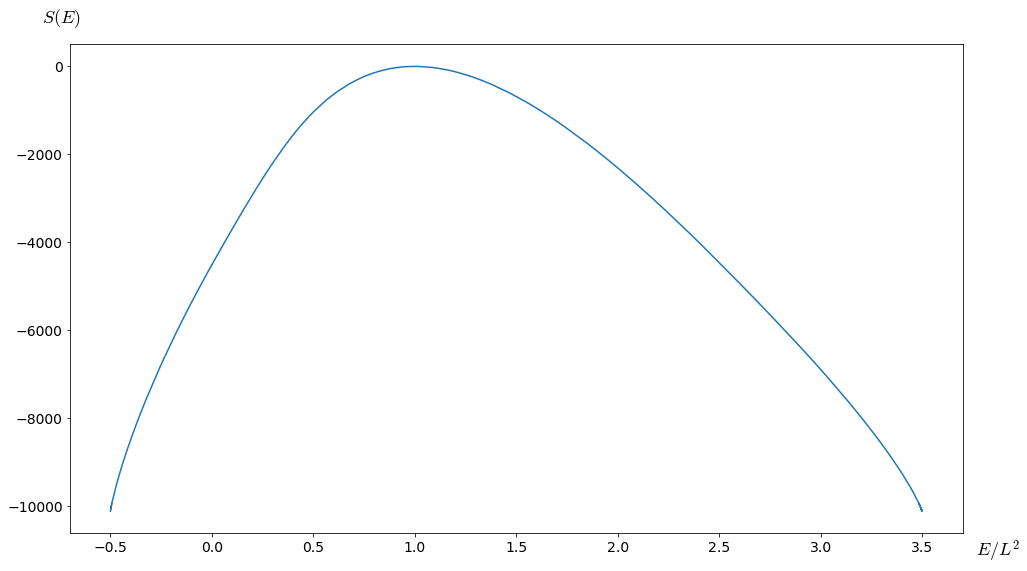

In [102]:
p = parameters[-1]

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

#ax.set_xlim([0.05, 0.43])
#ax.set_ylabel("$g(E)$", rotation=0, fontsize=18)
#ax.set_ylabel("$\ln g(E)$", rotation=0, fontsize=18)
ax.set_ylabel("$S(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

#plt.figure(figsize=(16, 9))

cool, heat, st = p['cool'], p['heat'], p['stitched']
L = st["L"]

plt.plot([x / (L*L) for x in st['S']], ([y for x, y in st['S'].items()]) , '-')
print("D={}; L={}".format(st["D"], st["L"], st["R"]))
#plt.title("$D={}; L={}$".format(st["D"], st["L"], st["R"]), fontsize=16)
#plt.yscale('log')
#plt.ylabel('$S(E)$', fontsize=16)
#plt.xlabel('$E$', fontsize=16)
#plt.grid()
plt.savefig("./images/S(E)_D{}_L{}_pretty_S.png".format(st["D"], st["L"]))
#plt.show()

D=1.5; L=96


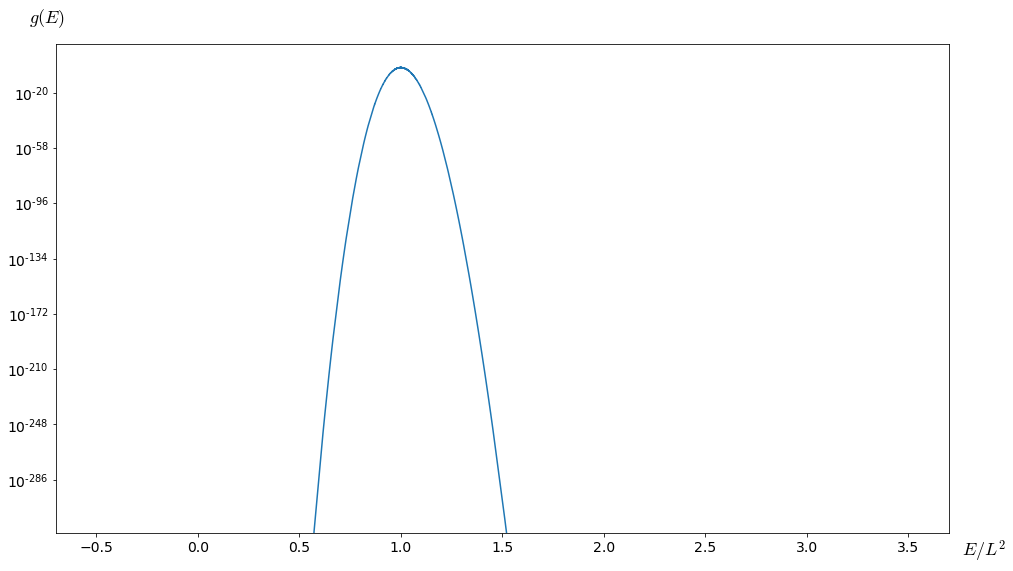

In [103]:
p = parameters[-1]

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

#ax.set_xlim([0.05, 0.43])
ax.set_ylabel("$g(E)$", rotation=0, fontsize=18)
#ax.set_ylabel("$\ln g(E)$", rotation=0, fontsize=18)
#ax.set_ylabel("$S(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

#plt.figure(figsize=(16, 9))

cool, heat, st = p['cool'], p['heat'], p['stitched']
L = st["L"]

plt.plot([x / (L*L) for x in st['S']], np.exp([y for x, y in st['S'].items()]) , '-')
print("D={}; L={}".format(st["D"], st["L"], st["R"]))
#plt.title("$D={}; L={}$".format(st["D"], st["L"], st["R"]), fontsize=16)
plt.yscale('log')
#plt.ylabel('$S(E)$', fontsize=16)
#plt.xlabel('$E$', fontsize=16)
#plt.grid()
plt.savefig("./images/S(E)_D{}_L{}_pretty_g_logscale.png".format(st["D"], st["L"]))
#plt.show()

Этот counter-based генератор (то есть n-ое генерируемое случайное число есть функция n: $r_n=f(n)$ и имеет период в $2^{128}$. Мы используем стандартную инициализацию, для каждой реплики мы делаем отступ в $2^{64}$ от предыдущей. Всего у нас $R=2^{17}$ реплик, для одного шага алгоритма требуется 10 Монте-Карло шагов по 2 случайных числа * размер решетки ($L_{max}=96$) $\approx 2 * 10^{5}$. Таких шагов алгоритма на практике требуется не более $2.5*10^6$, что вместе дает нам оценку в $5*10^{11}$ требуемых случайных чисел


In [138]:
(1/np.log(2)) * np.log(2 * 10 * (96**2) * 2.5*(10**6))

38.74534976054121

In [142]:
(1/np.log(2)) * np.log(5*10**11)

38.86313713864835